In [1]:
import warnings
warnings.filterwarnings('ignore')
import napari
import skimage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%gui qt
import skimage.filters
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
from fst.io import read
import dask.array as da

In [70]:
dset_path = '/groups/cosem/cosem/data/LoadID410_ROI1/ctl_id8_1.n5/volumes/raw/ch0/s4'
dset = da.from_array(read(dset_path), chunks=(1,-1,-1))
image = dset[dset.shape[0]//2].compute()

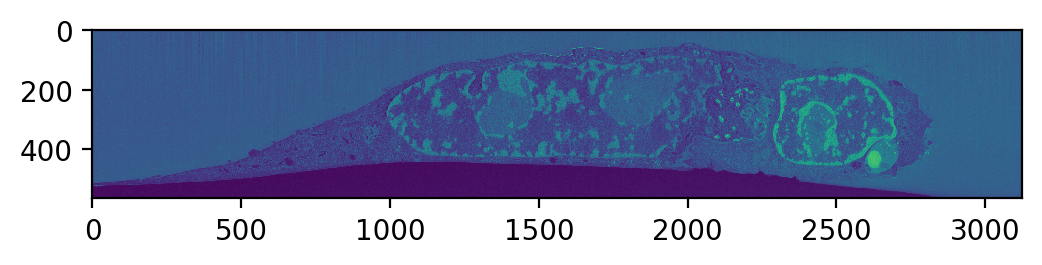

In [39]:
fig, axs = plt.subplots(dpi=200)
axs.imshow(image)

In [5]:
view = napari.Viewer()
#image layer
image_layer = view.add_image(image)

#labels layer. We create two labelled single-pixels for the two categories, so that 
#sklearn stays happy after one draws the first label
labels_layer = view.add_labels(data = np.zeros(image.shape),name = 'manual label')
labels_layer.data[0,0]=1
labels_layer.data[1,1]=2

#prediction layer
seg_layer = view.add_image(data = np.zeros(image.shape),name = 'predict',
                           opacity = 0.2, contrast_limits = [0,2], colormap = 'hsv')

In [65]:
filts = {}
filts['farid']= skimage.filters.farid(image)
filts['sobel'] = skimage.filters.sobel(image)
filts['gauss']= skimage.filters.gaussian(image,sigma = 10, preserve_range = True)
filts['gauss2'] = skimage.filters.gaussian(image,sigma = 20, preserve_range = True)
filts['prewitt'] = skimage.filters.prewitt(image)
filts['gauss_laplace'] = skimage.filters.laplace(skimage.filters.gaussian(image,sigma = 5,preserve_range=True),ksize=10)
filts['roberts'] = skimage.filters.roberts(skimage.filters.gaussian(image,sigma = 5,preserve_range=True))

In [66]:
v = napari.Viewer()
[v.add_image(a, name=n) for n,a in filts.items()]

[<Image layer 'farid' at 0x2aeaca16c080>,
 <Image layer 'sobel' at 0x2aea776fd080>,
 <Image layer 'gauss' at 0x2aea799e7320>,
 <Image layer 'gauss2' at 0x2aea799e71d0>,
 <Image layer 'prewitt' at 0x2aeaca7bc7f0>,
 <Image layer 'gauss_laplace' at 0x2aeaca824198>,
 <Image layer 'roberts' at 0x2aea799647f0>]

In [67]:
from dask import delayed 

In [68]:
delf = delayed(skimage.filters.farid)

In [74]:
edges = [delf(z) for z in dset]

In [76]:
res = da.compute(edges)

In [77]:
napari.view_image(np.array(res))